In [1]:
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import shap
import warnings
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from utils import scale_data, inverse_transform, lineplot, scatterplot
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

In [27]:
df = pd.read_excel('Data/all_data.xlsx')

In [28]:
df.tail()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,65496611844,positif,92,61198.382813


# PREPROCESSING

In [29]:
df = df.drop(columns=['Date'])

In [30]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
df['Sentimen'] = df['Sentimen'].map(sentimen_mapping)

In [31]:
X = df.drop('Close', axis=1)
y = df['Close']

In [32]:
X, y, scaler = scale_data(df)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# MODELING

In [34]:
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=150))
model.add(Dense(25))
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=[X_test, y_test])

Train on 292 samples, validate on 73 samples
Epoch 1/20
292/292 [==============================] - 2s 7ms/sample - loss: 0.0303 - val_loss: 0.0878
Epoch 2/20
292/292 [==============================] - 0s 206us/sample - loss: 0.0138 - val_loss: 0.0907
Epoch 3/20
292/292 [==============================] - 0s 151us/sample - loss: 0.0077 - val_loss: 0.1083
Epoch 4/20
292/292 [==============================] - 0s 133us/sample - loss: 0.0060 - val_loss: 0.0425
Epoch 5/20
292/292 [==============================] - 0s 134us/sample - loss: 0.0046 - val_loss: 0.0326
Epoch 6/20
292/292 [==============================] - 0s 142us/sample - loss: 0.0023 - val_loss: 0.0102
Epoch 7/20
292/292 [==============================] - 0s 143us/sample - loss: 8.8610e-04 - val_loss: 0.0011
Epoch 8/20
292/292 [==============================] - 0s 140us/sample - loss: 4.7289e-04 - val_loss: 0.0027
Epoch 9/20
292/292 [==============================] - 0s 153us/sample - loss: 4.5874e-04 - val_loss: 0.0013
Epoch 10/

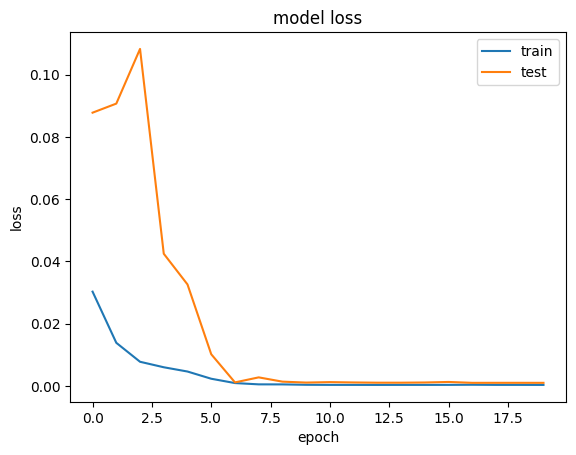

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [36]:
predictions_train = model.predict(X_train)
# Inverse transform predictions
inverse_predictions_train = inverse_transform(scaler, predictions_train)
# Inverse transform y_test
y_train_original = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]

compare_model_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_model_train.head()

,Predicted,Actual
0,23808.534604,23475.466797
1,23762.530914,22362.679688
2,23240.912470,22353.349609
3,22583.961663,22435.513672
4,22700.096473,22429.757813


In [37]:
predictions_test = model.predict(X_test)
# Inverse transform predictions
inverse_predictions_test = inverse_transform(scaler, predictions_test)
# Inverse transform y_test
y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_model_test.head()

,Predicted,Actual
0,41646.473104,42270.527344
1,42918.737483,43652.250000
2,43582.103186,43869.152344
3,43685.720183,43997.902344
4,44338.113784,43739.542969


# MATRIKS EVALUASI

In [38]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

# Menghitung R-squared
r2_xgb_train = r2_score(y_train, predictions_train)
r2_xgb_test = r2_score(y_test, predictions_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 721.95492815193
Root Mean Squared Error (RMSE) Test Set: 1311.5591053127732

R-squared Train Set: 0.9763296600017322
R-squared Test Set: 0.9269812676184922


# VISUALISASI

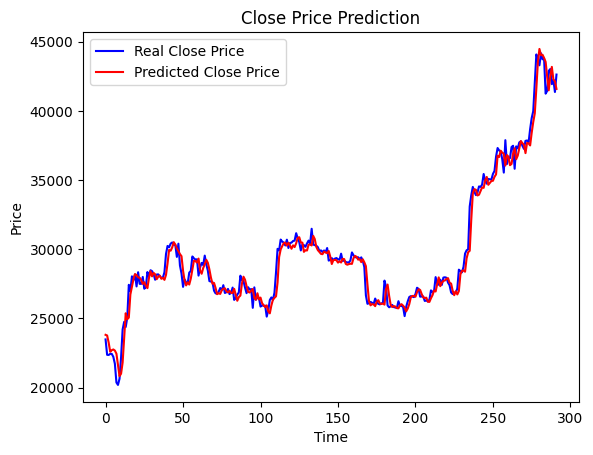

In [39]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)

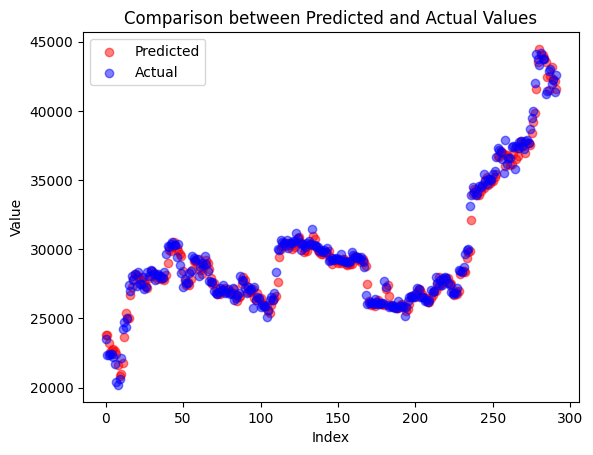

In [40]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)

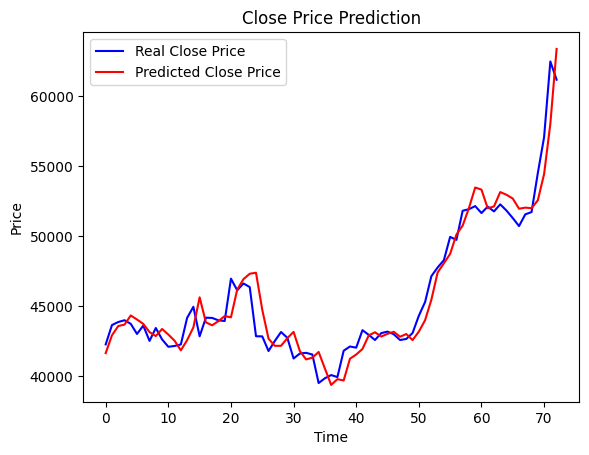

In [41]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

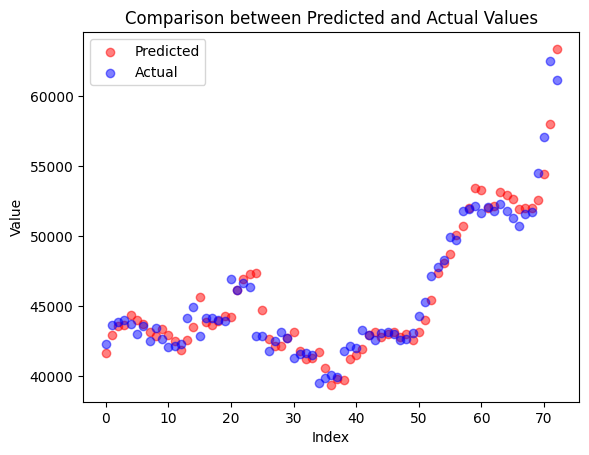

In [42]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [43]:
features = ["Open", "High", "Low", "Adj_Close", "Volume", "Sentimen", "Index"]

# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, X_train)
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test)
# init the JS visualization code
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

# TEST DENGAN DATA BARU

In [44]:
dt = pd.read_excel('all_data_validation.xlsx')

In [45]:
dt = dt.drop(columns=["Date"])

In [46]:
dt.describe()

,Open,High,Low,Adj_Close,Volume,Index,Close
count,31.000000,31.000000,31.000000,31.000000,3.100000e+01,31.000000,31.000000
mean,67372.752394,69272.725933,65532.276714,67702.439264,4.665864e+10,56.419355,67702.439264
std,3292.243235,2911.385403,3273.325051,3157.882425,2.025387e+10,15.751771,3157.882425
min,61168.062500,62458.699219,59323.910156,61912.773438,1.713024e+10,35.000000,61912.773438
25%,64693.548828,68068.425782,62617.595703,65403.253907,3.079077e+10,45.500000,65403.253907
50%,68299.257813,69170.625000,65655.531250,68330.414063,4.448035e+10,52.000000,68330.414063
75%,69770.613282,71456.761719,68472.476563,69925.820312,6.107452e+10,63.000000,69925.820312
max,73079.375000,73750.070313,71334.093750,73083.500000,1.028029e+11,100.000000,73083.500000


In [47]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
dt['Sentimen'] = dt['Sentimen'].map(sentimen_mapping)

In [48]:
X_ = dt.drop(columns=['Close'])
y_ = dt['Close']

In [49]:
X, y, scalers = scale_data(dt)

In [50]:
predictions = model.predict(X)
# inverse transform predictions
inverse_predictions_new = inverse_transform(scaler, predictions)
# Inverse transform y_test
y_test_original_new = scaler.inverse_transform(np.concatenate((X[:, -1, :], y.reshape(-1, 1)), axis=1))[:, -1]

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_new, 'Actual': y_test_original_new})
compare_model_test.head()

,Predicted,Actual
0,23028.952589,20630.750967
1,23736.504963,24939.978206
2,24792.651728,44498.894232
3,36489.073268,27341.079872
4,35830.110278,36075.298051


In [51]:
mse_model_newdata = mean_squared_error(y_test_original_new, inverse_predictions_new)
rmse_model_newdata = np.sqrt(mse_model_newdata)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_newdata)
print("======================================================")

# Menghitung R-square
r2_xgb_test = r2_score(y_test_original_new, inverse_predictions_new)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Test Set: 9016.09917192204
R-squared Test Set: 0.3719105238735684


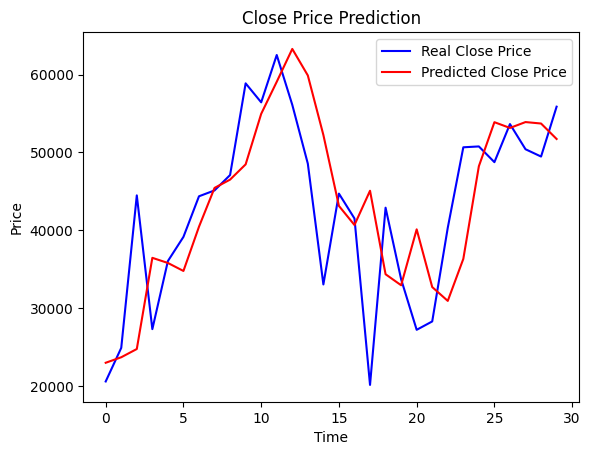

In [52]:
lineplot(y_test_original_new, inverse_predictions_new)

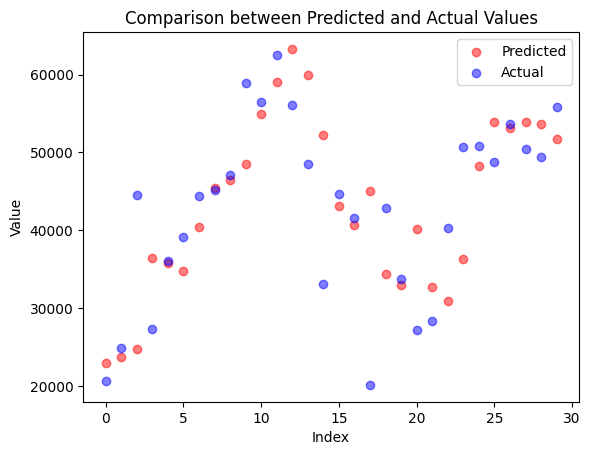

In [53]:
scatterplot(y_test_original_new, inverse_predictions_new)